# Inicialização

In [1]:
import psycopg2
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import scipy

from imblearn.under_sampling import RandomUnderSampler
import imblearn.pipeline

#import warnings
#warnings.filterwarnings("ignore")

In [2]:
dict_connect = {
    "dbname" : "lista4",
    "user" : "postgres",
    "password": "123321",
    "host": "localhost"
}
conn = psycopg2.connect(**dict_connect)
raw_data = pd.read_sql('SELECT * FROM tb_whatsapp_messages', con=conn)
raw_data.info()

C:\Users\Pichau\AppData\Local\Temp\ipykernel_16264\3275608030.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  raw_data = pd.read_sql('SELECT * FROM tb_whatsapp_messages', con=conn)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407957 entries, 0 to 407956
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      407957 non-null  int64         
 1   date_message            407957 non-null  datetime64[ns]
 2   id_member_anonymous     407957 non-null  object        
 3   ddi                     407957 non-null  object        
 4   ddd                     406311 non-null  object        
 5   country                 407866 non-null  object        
 6   country_iso3            407866 non-null  object        
 7   state                   406311 non-null  object        
 8   id_group_anonymous      407957 non-null  object        
 9   media                   185568 non-null  object        
 10  media_type              187528 non-null  object        
 11  media_url               132949 non-null  object        
 12  has_media               407957

# Embedding

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin


def text_to_vector(text, model):
    words = text.split()
    words = [word for word in words if word in model.wv]
    
    if len(words) == 0:
        return np.zeros(model.vector_size)

    word_vectors = np.array([model.wv[word] for word in words])
    return np.mean(word_vectors, axis=0)


class Embedding(BaseEstimator, TransformerMixin):
    def __init__(self, tipo_embedding = "BOW", n_grams = 1):
        self.tipo_embedding = tipo_embedding
        self.n_grams = n_grams
        self.QNT_FEATURES = 500

    def fit(self, X, y=None):

        if self.tipo_embedding == "BOW":
            self.vetorizador = CountVectorizer(max_features = self.QNT_FEATURES, ngram_range = (1,self.n_grams))
            self.vetorizador.fit(X)

        elif self.tipo_embedding == "TF-IDF":
            self.vetorizador = TfidfVectorizer(max_features = self.QNT_FEATURES, ngram_range = (1,self.n_grams))
            self.vetorizador.fit(X)

        elif self.tipo_embedding == "WORD2VEC":
            w2v_modelo = Word2Vec(
                sg = 0, # cbow
                window = self.n_grams * 2,
                vector_size  = self.QNT_FEATURES,
                min_count = 3,
                alpha = 0.03,
                min_alpha = 0.007
            )

            textos = X
            lista_lista_tokens = [texto.split() for texto in textos]
            w2v_modelo.build_vocab(lista_lista_tokens, progress_per = 5000)

            w2v_modelo.train(lista_lista_tokens,
                 total_examples = w2v_modelo.corpus_count,
                 epochs = 400,
            )

            self.w2v_modelo = w2v_modelo

        else:
            raise Exception("Este embedding não está implementado ou não existe")
        
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        if self.tipo_embedding == "BOW":
            bag_of_words = self.vetorizador.transform(X.iloc[:,0])
            bow = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns=self.vetorizador.get_feature_names_out())
            bow.index = X.index
            X = pd.concat([X, bow], axis = 1)
    
        elif self.tipo_embedding == "TF-IDF":
            tf_idf = self.vetorizador.transform(X.iloc[:,0])
            tfidf = pd.DataFrame.sparse.from_spmatrix(tf_idf, columns=self.vetorizador.get_feature_names_out())
            tfidf.index = X.index
            X = pd.concat([X, tfidf], axis = 1)
    
        elif self.tipo_embedding == "WORD2VEC":
            textos = X.iloc[:,0]
            matriz = np.array([text_to_vector(texto, self.w2v_modelo) for texto in textos])
            word2vec = pd.DataFrame(data = matriz, index = X.index, columns = ["w2v_" + str(i) for i in range(1,self.QNT_FEATURES+1)])
            X = pd.concat([X, word2vec], axis = 1)
            
        
        else:
            raise Exception("Este embedding não está implementado ou não existe")

        X = X.drop(X.columns[[0,1]], axis=1)
        return X


In [4]:
textos = raw_data["text_content_anonymous"]
textos.dropna(inplace = True)
textos = textos[(textos != 'None') & (textos != "")]
textos = textos[ textos.apply(lambda x: len(x.split()) > 10)]
textos = textos.sample(50000, random_state = 23)

In [5]:
import nltk
from nltk.corpus import stopwords
import re
from urllib.parse import urlparse
import spacy

RENOMEAR = {
    "combr" : "",
    "com" : "",
    "https": "",
    "www": ""
    
}

STOP_WORDS = list(stopwords.words('portuguese'))


def extract_root_domain(text):
    url_pattern = r'(https?://[^\s]+)'
    
    def get_root_domain(url):
        try:
            parsed_url = urlparse(url)
            domain_parts = parsed_url.netloc.split('.')
            
            if len(domain_parts) >= 2:
                root_domain = '.'.join(domain_parts[-2:])
            else:
                root_domain = parsed_url.netloc
            
            return root_domain.capitalize()
        except ValueError:
            return ''
    
    return re.sub(url_pattern, lambda match: get_root_domain(match.group(0)), text)
    
def preprocessamento_regras_assoc(texto):

    texto_filtrado = texto.replace("*", "").replace("\n", " ")
    
    texto_filtrado = extract_root_domain(texto_filtrado)

    texto_filtrado = re.sub(r'[^\w\s]', '', texto_filtrado)

    texto_filtrado = ' '.join([token.text for token in nlp(texto_filtrado) if token.pos_ == "PROPN" or token.pos_ == "VERB"]).lower()

    for k, v in RENOMEAR.items():
        texto_filtrado = texto_filtrado.replace(k, v)

    texto_filtrado = " ".join( palavra for palavra in texto_filtrado.split() if palavra not in STOP_WORDS )

    return texto_filtrado

RENOMEAR = {
    "combr" : "",
    "com" : "",
    "https": "",
    "www": ""
}
nlp = spacy.load('pt_core_news_sm')
textos_processados = textos.apply(preprocessamento_regras_assoc)
textos_processados.dropna(inplace = True)
textos_processados = textos_processados[textos_processados != ""]

In [6]:
textos_processados

10655                           programa hora união youtube
174768             bastidores metrô sabesp paulo vergonhoso
327418            israelenses fogem assista pensandodireita
40598                                  r aplicadas amazonas
281361    pe produz lançado raquel lyra investir blog al...
                                ...                        
19375     flávio dino bate pf mostra ministério justiça ...
51822                              armam emboscada salvador
90940     possuem válidos correios celular navegar whats...
344348                                  ver política brasil
407498                 passa morre taylor swift rio janeiro
Name: text_content_anonymous, Length: 49817, dtype: object

In [7]:
embedding_word2vec = Embedding(tipo_embedding = "WORD2VEC")
X_word2vec = embedding_word2vec.fit_transform(textos_processados)

embedding_tfidf = Embedding(tipo_embedding = "TF-IDF")
X_tfidf = embedding_tfidf.fit_transform(textos_processados)

embedding_bow = Embedding(tipo_embedding = "BOW")
X_bow = embedding_bow.fit_transform(textos_processados)



In [8]:
X_escolhido = X_tfidf

# LDA

In [9]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=4, random_state=0)
lda.fit(X_escolhido)

for index, topic in enumerate(lda.components_):
    print(f"Top 10 palavras no tópico #{index}:")
    print([X_escolhido.columns[i] for i in topic.argsort()[-10:]])

Top 10 palavras no tópico #0:
['tme', 'abrir', 'conseguir', 'gaza', 'pode', 'pt', 'canal', 'hamas', 'israel', 'whatsapp']
Top 10 palavras no tópico #1:
['senhor', 'entenda', 'oantagonismo', 'ter', 'pode', 'ver', 'partilhe', 'fazer', 'revistaonlinenews', 'deus']
Top 10 palavras no tópico #2:
['news', 'user', 'facebook', 'ceará', 'saiba', 'vídeo', 'instagram', 'youtube', 'veja', 'terrabrasilnoticias']
Top 10 palavras no tópico #3:
['diz', 'portalcidadenews', 'faz', 'governo', 'stf', 'bolsonaro', 'lula', 'pensandodireita', 'assista', 'brasil']


# GSDMM 

In [10]:
from gsdmm import MovieGroupProcess

corpus_tokens = [doc.split() for doc in textos_processados]
vocab = X_escolhido.columns

mgp = MovieGroupProcess(K=3, alpha=0.1, beta=0.1, n_iters=30)
y = mgp.fit(corpus_tokens, len(vocab))

for topic_num, topic in enumerate(mgp.cluster_word_distribution):
    sorted_topic = sorted(topic.items(), key=lambda k: k[1], reverse=True)
    print(f"Tópico {topic_num}: {sorted_topic[:10]}")

In stage 0: transferred 30605 clusters with 3 clusters populated
In stage 1: transferred 18401 clusters with 3 clusters populated
In stage 2: transferred 10469 clusters with 3 clusters populated
In stage 3: transferred 7163 clusters with 3 clusters populated
In stage 4: transferred 5579 clusters with 3 clusters populated
In stage 5: transferred 5023 clusters with 3 clusters populated
In stage 6: transferred 4644 clusters with 3 clusters populated
In stage 7: transferred 4420 clusters with 3 clusters populated
In stage 8: transferred 4397 clusters with 3 clusters populated
In stage 9: transferred 4314 clusters with 3 clusters populated
In stage 10: transferred 4329 clusters with 3 clusters populated
In stage 11: transferred 4251 clusters with 3 clusters populated
In stage 12: transferred 4190 clusters with 3 clusters populated
In stage 13: transferred 4124 clusters with 3 clusters populated
In stage 14: transferred 4115 clusters with 3 clusters populated
In stage 15: transferred 4088 cl

# PTM 

In [11]:
import gensim
from gensim import corpora

corpus_tokens = [doc.lower().split() for doc in textos_processados]
dictionary = corpora.Dictionary(corpus_tokens)
corpus_bow = [dictionary.doc2bow(doc) for doc in corpus_tokens]

lda_model = gensim.models.LdaModel(corpus_bow, num_topics=3, id2word=dictionary, passes=25)

for idx, topic in lda_model.print_topics(-1):
    print(f"Tópico {idx}: {topic}")

Tópico 0: 0.270*"user" + 0.010*"facebook" + 0.006*"ceará" + 0.005*"clicar" + 0.004*"bolsonaro" + 0.003*"entenderam" + 0.003*"paulo" + 0.003*"luiz" + 0.002*"josé" + 0.002*"pt"
Tópico 1: 0.029*"brasil" + 0.028*"whatsapp" + 0.022*"lula" + 0.018*"assista" + 0.018*"inelegível" + 0.017*"pensandodireita" + 0.016*"terrabrasilnoticias" + 0.013*"veja" + 0.012*"israel" + 0.009*"bolsonaro"
Tópico 2: 0.013*"deus" + 0.010*"youtube" + 0.009*"instagram" + 0.008*"brasil" + 0.007*"fazer" + 0.006*"pode" + 0.005*"senhor" + 0.005*"jesus" + 0.004*"ver" + 0.003*"bolsonaro"


# BERTopic

In [14]:
from bertopic import BERTopic

topic_model = BERTopic(language = "brazilian portuguese", min_topic_size = 350)
topics, probabilities = topic_model.fit_transform(textos_processados)

print(topic_model.get_topic_info())
print(topic_model.get_topic(0)) 

    Topic  Count                                         Name  \
0      -1  16565       -1_user_pensandodireita_assista_brasil   
1       0  13353             0_inelegível_lula_bolsonaro_pode   
2       1   3174    1_brasil_brazil_brazilnewsinforma_informa   
3       2   3075             2_whatsapp_canal_resolverá_abrir   
4       3   2060                3_israel_hamas_gaza_palestina   
5       4   1967       4_terrabrasilnoticias_entenda_veja_diz   
6       5   1785  5_portalcidadenews_portal_rondônia_repórter   
7       6   1748                   6_deus_senhor_jesus_cristo   
8       7   1379                 7_youtube_180_ligue_consulte   
9       8    956           8_brasil_bolsonaro_entenderam_lula   
10      9    896              9_instagram_siga_clique_mossoró   
11     10    678    10_revistaonlinenews_fazer_pode_emagrecer   
12     11    655                 11_vídeo_rio_partilhe_grande   
13     12    651      12_vídeo_terrabrasilnoticias_veja_hamas   
14     13    500         

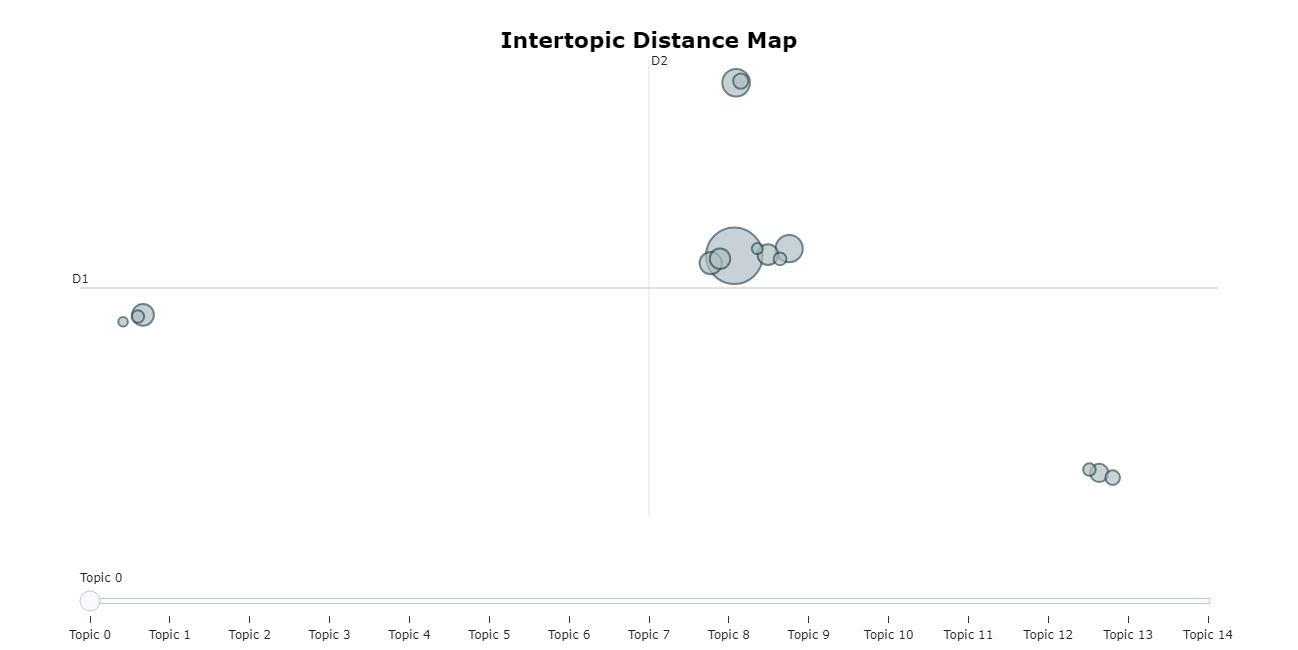

In [15]:
topic_model.visualize_topics()